In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from highlight_text import fig_text, ax_text
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import scipy.stats as stats
from matplotlib import colormaps
import matplotlib.colors as mcolors

from mplsoccer import Pitch, add_image

from PIL import Image
import urllib
import glob
import os

In [2]:
plt.style.use("soc_base.mplstyle")

font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if (y.split(".")[-1] == "ttf") or (y.split(".")[-1] == "otf"):
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

In [3]:
df_shooting = pd.read_csv('../data/fbref_player_shooting_wsl.csv', index_col=0)
df_passing = pd.read_csv('../data/fbref_player_passing_wsl.csv', index_col=0)

In [4]:
columns_to_keep = ['Player', 'goals', 'xG','npxG']
# Drop other columns
columns_to_drop = [col for col in df_shooting.columns if col not in columns_to_keep]
df_shooting = df_shooting.drop(columns=columns_to_drop)

In [5]:
columns_to_keep = ['Player', 'Nation', 'Pos', 'Squad', 'Age', '90s', 'total_comp', 'xAG', 'xA']
# Drop other columns
columns_to_drop = [col for col in df_passing.columns if col not in columns_to_keep]
df_passing = df_passing.drop(columns=columns_to_drop)

In [6]:
df = pd.merge(df_shooting, df_passing, how = 'left', on = [ 'Player', 'Player'])

In [7]:
df

,Player,goals,xG,npxG,Nation,Pos,Squad,Age,90s,total_comp,xAG,xA
0,Princess Ademiluyi,0,0.2,0.2,eng ENG,"FW,DF",West Ham,18.0,0.8,11,0.9,0.1
1,Michelle Agyemang,3,3.1,3.1,eng ENG,"FW,MF",Brighton,18.0,6.4,116,1.0,0.3
2,Olga Ahtinen,1,0.2,0.2,fi FIN,MF,Tottenham,NaN,4.4,217,0.1,0.3
3,Asmita Ale,0,0.7,0.7,eng ENG,DF,Leicester City,22.0,15.5,526,1.8,1.5
4,Laia Aleixandri,1,0.7,0.7,es ESP,"DF,MF",Manchester City,23.0,18.4,1467,0.4,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...
312,Lotte Wubben-Moy,1,0.4,0.4,eng ENG,DF,Arsenal,25.0,5.8,415,0.2,0.2
313,Ayaka Yamashita,0,0.0,0.0,jp JPN,GK,Manchester City,28.0,10.0,542,0.2,0.3
314,Shae Yanez,0,0.0,0.0,us USA,GK,Crystal Palace,27.0,19.0,510,0.0,0.0
315,Shelina Zadorsky,0,0.4,0.4,ca CAN,DF,West Ham,31.0,18.4,616,0.1,0.5


In [8]:
# Function to extract short names
def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

# Applying the function to create 'shortName' column
df['Player'] = df['Player'].apply(get_short_name)
df['90s'] = df['90s'].astype(float)
df['nineties'] = df['90s'] 

df = df.drop(columns=['90s'])

In [9]:
df_plot = df[df['nineties'] > 5]
# df_plot

In [10]:
df_plot = df_plot.assign(xg_per_90 = lambda x: x.xG/x.nineties)
df_plot = df_plot.assign(xa_per_90 = lambda x: x.xA/x.nineties)
df_plot = df_plot.assign(xag_per_90 = lambda x: x.xAG/x.nineties)

In [11]:
df_plot.sort_values(by='xa_per_90')

,Player,goals,xG,npxG,Nation,Pos,Squad,Age,total_comp,xAG,xA,nineties,xg_per_90,xa_per_90,xag_per_90
13,S. Baggaley,0,0.0,0.0,eng ENG,GK,Brighton,27.0,412,0.0,0.0,14.0,0.000000,0.000000,0.000000
40,L. Bühler,0,0.0,0.0,ch SUI,DF,Tottenham,28.0,171,0.0,0.0,5.1,0.000000,0.000000,0.000000
36,C. Brosnan,0,0.0,0.0,ie IRL,GK,Everton,28.0,734,0.0,0.0,21.0,0.000000,0.000000,0.000000
59,S. D'Angelo,0,0.0,0.0,ca CAN,GK,Aston Villa,31.0,757,0.0,0.0,21.6,0.000000,0.000000,0.000000
64,D. v. Domselaar,0,0.0,0.0,nl NED,GK,Arsenal,24.0,469,0.0,0.0,15.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,M. Fowler,6,3.9,2.5,au AUS,"FW,MF",Manchester City,21.0,400,4.9,4.6,12.5,0.312000,0.368000,0.392000
165,C. Macario,6,4.0,3.3,us USA,"MF,FW",Chelsea,24.0,326,3.3,3.3,8.8,0.454545,0.375000,0.375000
79,A. Fujino,1,1.9,1.9,jp JPN,"FW,MF",Manchester City,20.0,393,3.4,4.7,12.3,0.154472,0.382114,0.276423
122,L. James,3,3.0,3.0,eng ENG,"FW,MF",Chelsea,22.0,205,1.3,2.7,6.3,0.476190,0.428571,0.206349


In [12]:
df_plot['zscore'] = stats.zscore(df_plot['xg_per_90'])*.4 + stats.zscore(df_plot['xa_per_90'])*.6
df_plot['annotated'] = [True if x > df_plot['zscore'].quantile(.89) else False for x in df_plot['zscore']]

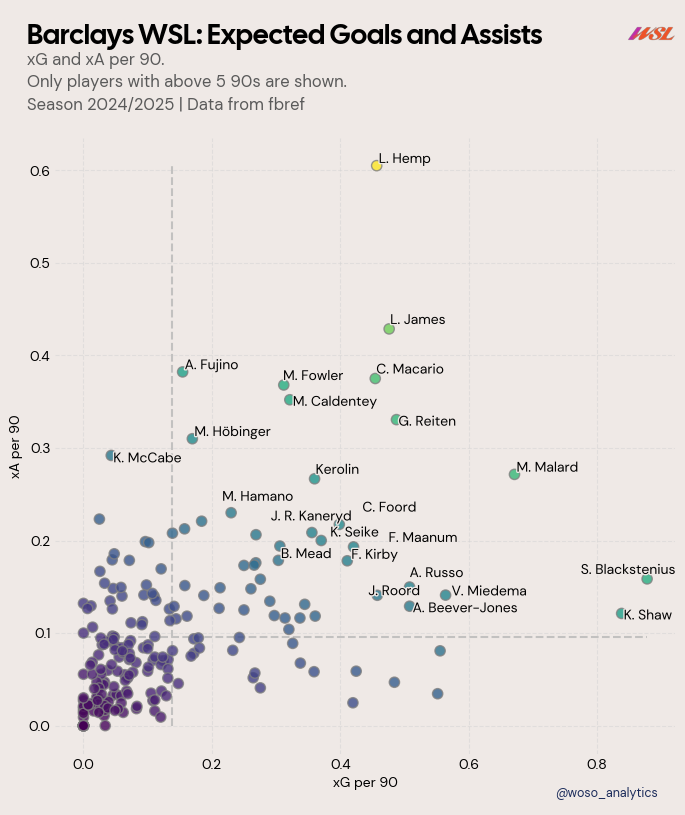

In [15]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = plt.subplot()
ax.grid(visible=True, ls='--', color='lightgrey', alpha=.5)
# Remove top & right spines and change the color.
ax.spines[["top", "right", "left", "bottom"]].set_visible(False)
ax.scatter(
    df_plot['xg_per_90'], df_plot['xa_per_90'], 
    c=df_plot['zscore'], 
    # cmap='magma', 
    zorder=3, ec='grey', s=55, alpha=0.8)
    
texts = []
annotated_df = df_plot[df_plot['annotated']].reset_index(drop=True)
for index in range(annotated_df.shape[0]):
    texts += [
        ax.text(
            x=annotated_df['xg_per_90'].iloc[index], y=annotated_df['xa_per_90'].iloc[index],
            s=f"{annotated_df['Player'].iloc[index]}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='DM Sans'
        )
    ]

adjust_text(texts, only_move={'points':'y', 'text':'xy', 'objects':'xy'})

ax.vlines(df_plot['xg_per_90'].mean(), df_plot['xa_per_90'].min(), df_plot['xa_per_90'].max(), ls='--', color='#c2c1c0')
ax.hlines(df_plot['xa_per_90'].mean(), df_plot['xg_per_90'].min(), df_plot['xg_per_90'].max(), ls='--', color='#c2c1c0')

ax.tick_params(
    # color = None, 
    length = 0, 
    # labelsize = 0,
)

ax.set_xlabel('xG per 90')
ax.set_ylabel('xA per 90')

fig_text(
    x = 0.09, y = .99, 
    s = "Barclays WSL: Expected Goals and Assists",
    va = "bottom", ha = "left",
    fontsize = 20, color = "black", font = "Cal Sans", weight = "bold"
)

fig_text(
    x = 0.09, y = 0.91, 
    s = "xG and xA per 90.\nOnly players with above 5 90s are shown.\nSeason 2024/2025 | Data from fbref",
    va = "bottom", ha = "left",
    fontsize = 12, color = "#5A5A5A", font = "DM Sans"
)

fotmob_url = 'https://images.fotmob.com/image_resources/logo/leaguelogo/9227.png'
# fotmob_url ='https://images.fotmob.com/image_resources/logo/leaguelogo/9907.png'
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}'))
ax_timage = add_image(club_icon, fig, left=0.84, bottom=0.98, width=0.060, height=0.060)

fig_text(
    x = 0.75, y = 0.069,
    s = "@woso_analytics",
    color = '#1C2C5B',
    size = 9,
    annotationbbox_kw={"xycoords": "figure fraction"}
)

plt.savefig(
	"../figures/wsl_xG_xA.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"../figures/wsl_xG_xA_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)

In [16]:
df_plot['zscore'] = stats.zscore(df_plot['xg_per_90'])*.4 + stats.zscore(df_plot['xag_per_90'])*.6
df_plot['annotated'] = [True if x > df_plot['zscore'].quantile(.9) else False for x in df_plot['zscore']]

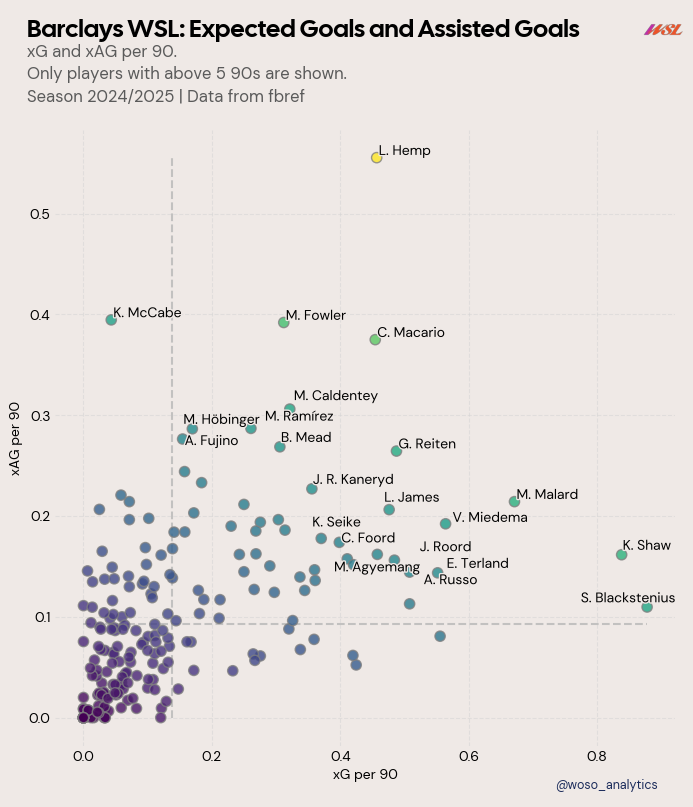

In [17]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = plt.subplot()
ax.grid(visible=True, ls='--', color='lightgrey', alpha=.5)
# Remove top & right spines and change the color.
ax.spines[["top", "right", "left", "bottom"]].set_visible(False)
ax.scatter(
    df_plot['xg_per_90'], df_plot['xag_per_90'], 
    c=df_plot['zscore'], 
    # cmap='magma', 
    zorder=3, ec='grey', s=55, alpha=0.8)
    
texts = []
annotated_df = df_plot[df_plot['annotated']].reset_index(drop=True)
for index in range(annotated_df.shape[0]):
    texts += [
        ax.text(
            x=annotated_df['xg_per_90'].iloc[index], y=annotated_df['xag_per_90'].iloc[index],
            s=f"{annotated_df['Player'].iloc[index]}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='DM Sans'
        )
    ]

adjust_text(texts, only_move={'points':'y', 'text':'xy', 'objects':'xy'})

# ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
# ax.set_xlim(0)
# ax.set_ylim(0,1)

ax.set_xlabel('xG per 90')
ax.set_ylabel('xAG per 90')

ax.vlines(df_plot['xg_per_90'].mean(), df_plot['xag_per_90'].min(), df_plot['xag_per_90'].max(), ls='--', color='#c2c1c0')
ax.hlines(df_plot['xag_per_90'].mean(), df_plot['xg_per_90'].min(), df_plot['xg_per_90'].max(), ls='--', color='#c2c1c0')

ax.tick_params(
    # color = None, 
    length = 0, 
    # labelsize = 0,
)

fig_text(
    x = 0.09, y = .99, 
    s = "Barclays WSL: Expected Goals and Assisted Goals",
    va = "bottom", ha = "left",
    fontsize = 18, color = "black", font = "Cal Sans", weight = "bold"
)

fig_text(
    x = 0.09, y = 0.91, 
    s = "xG and xAG per 90.\nOnly players with above 5 90s are shown.\nSeason 2024/2025 | Data from fbref",
    va = "bottom", ha = "left",
    fontsize = 12, color = "#5A5A5A", font = "DM Sans"
)

fotmob_url = 'https://images.fotmob.com/image_resources/logo/leaguelogo/9227.png'
# fotmob_url ='https://images.fotmob.com/image_resources/logo/leaguelogo/9907.png'
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}'))
ax_timage = add_image(club_icon, fig, left=0.86, bottom=0.98, width=0.050, height=0.050)

fig_text(
    x = 0.75, y = 0.069,
    s = "@woso_analytics",
    color = '#1C2C5B',
    size = 9,
    annotationbbox_kw={"xycoords": "figure fraction"}
)

plt.savefig(
	"../figures/wsl_xG_xAG.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"../figures/wsl_xG_xAG_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)